In [17]:
from __future__ import print_function, division

import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, LSTM
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop

import sys
import numpy as np
from utils import show_model 

import data_functions

In [18]:
#Load data from already created pickle file
words, X, dataX, dataY, n_words, n_vocab, index2word, word2index = data_functions.load_from_pickle("data.pickle")

In [19]:
from keras.utils import np_utils
# one hot encode the output variable

X100 = dataX[0:100]
trainX = np_utils.to_categorical(X100)
n_vocab = (trainX.shape[2])

# trainX.shape
# print(trainX[0])
# print(trainX.shape)
# print(X100[0])
# print(n_vocab)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
disc_inputs (InputLayer)     (None, 100, 1)            0         
_________________________________________________________________
disc_LSTM (LSTM)             [(None, 1000), (None, 100 4008000   
_________________________________________________________________
dropout_83 (Dropout)         (None, 1000)              0         
_________________________________________________________________
disc_dense1 (Dense)          (None, 50)                50050     
_________________________________________________________________
dropout_84 (Dropout)         (None, 50)                0         
_________________________________________________________________
disc_dense2 (Dense)          (None, 1)                 51        
Total params: 4,058,101
Trainable params: 4,058,101
Non-trainable params: 0
_________________________________________________________________


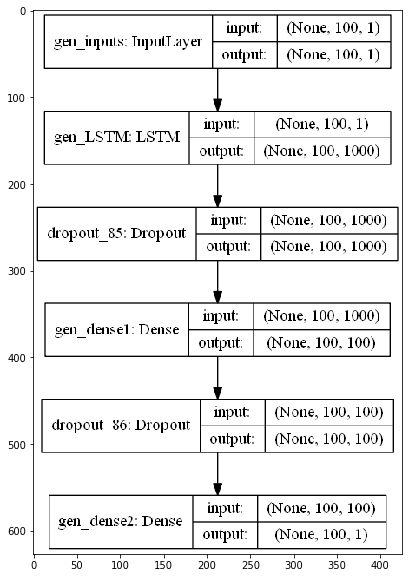

Generator model created


In [98]:
class GAN():
    def __init__(self):
       
        self.input_shape = 100
        self.noise_dim = 100
        self.hidden_size = 1000
        self.img_shape = (self.input_shape, 1)

        optimizer = RMSprop(lr=0.001)   #Adam

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='mse', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.noise_dim,1))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        noise_shape = (self.noise_dim,1)

        
         ################# LSTM gen ##############

        gen_inputs = Input(shape=noise_shape, name='gen_inputs') 

        gen_lstm = LSTM(self.hidden_size, return_sequences=True, name='gen_LSTM')
        gen_lstm_out = gen_lstm(gen_inputs) 

        gen_dropout_out = Dropout(0.2)(gen_lstm_out)
        dense1_out = Dense(100, activation='relu', name='gen_dense1')(gen_dropout_out)
        dropout2_out = Dropout(0.2)(dense1_out)   
        gen_out = Dense(1, activation='sigmoid', name='gen_dense2')(dropout2_out)
        
        model = Model(gen_inputs, gen_out)

        ##########################################
        
        
        
        
        
#          ################# LSTM gen ##############

#         gen_inputs = Input(shape=noise_shape, name='gen_inputs') 

#         gen_lstm = LSTM(self.hidden_size, name='gen_LSTM')
#         gen_lstm_out = gen_lstm(gen_inputs) 
        
#         gen_dropout = Dropout(0.2)
#         gen_dropout_out = gen_dropout(gen_lstm_out)
        
#         gen_reshape = Reshape((self.noise_dim,1), name='gen_reshape')
#         gen_out = gen_reshape(gen_dropout_out)

#         model = Model(gen_inputs, gen_out)
        
#         print(model.summary())
# #         show_model(model, 10, 10)

#         ################################################

        print(model.summary())
        show_model(model, 10, 10)

        noise = Input(shape=noise_shape)
        img = model(noise)
        print('Generator model created')
        
        return Model(noise, img)

    def build_discriminator(self):

        img_shape = self.img_shape
#         print(self.img_shape)
        hidden_size = 100

        #LSTM discriminator
        disc_inputs = Input(shape=(img_shape), name='disc_inputs') 

        disc_lstm = LSTM(self.hidden_size, return_state=True, name='disc_LSTM')
        _, disc_state_h, disc_state_c = disc_lstm(disc_inputs)  
        
        disc_dropout = Dropout(0.2)
        disc_dropout_out = disc_dropout(disc_state_h)

        disc_dense1 = Dense(50, activation='relu', name='disc_dense1')
        disc_dense1_out = disc_dense1(disc_dropout_out)
        
        disc_dropout2 = Dropout(0.2)
        disc_dropout2_out = disc_dropout2(disc_dense1_out)        

        disc_dense2 = Dense(1, activation='sigmoid', name='disc_dense2')
        disc_out = disc_dense2(disc_dropout2_out)

        model = Model(disc_inputs, disc_out)

        print(model.summary())
#         show_model(model, 10, 10)  
        
        img = Input(shape=(img_shape))
        validity = model(img)
        print('Discriminator model created')

        return Model(img, validity)

    def train(self, X_train, epochs, batch_size=128, save_interval=50, only_first_col=True):

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
#             print('imgs shape=',imgs.shape)

            noise = self.generate_noise(half_batch, self.noise_dim, only_first_col)
#             print('noise shape=',noise.shape)
            
            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = self.generate_noise(batch_size, self.noise_dim, only_first_col)

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # Plot the progress
            if epoch % 10 == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch, only_first_col)

    def save_imgs(self, epoch, only_first_col):
        r = 2
        noise = self.generate_noise(r , self.noise_dim, only_first_col)
        gen_imgs = self.generator.predict(noise)
        pred = np.reshape(gen_imgs * float(n_vocab), (r,-1))
        pred[pred < 0] = 0
        pred[pred >= n_vocab-1] = 0
        pred = pred.astype(int)        
        for p in pred:
            s = [index2word[i+1] for i in p]
            s = ' '.join(s)
            print(s)
            print('----------------------')
        self.combined.save_weights("weights_gan_lstm_lstm_combined.hf5")
            
    def generate_noise(self,rows, cols, only_first_col):
        noise = np.random.normal(0, 1, (rows , cols))
        if only_first_col:
            noise[:,1:] = 0.
        noise = np.reshape(noise, (-1, self.noise_dim, 1))
        return(noise)

gan = GAN()

In [99]:
gan.train(X[0:200], epochs=30000, batch_size=32, save_interval=200, only_first_col=False)

KeyboardInterrupt: 